<a href="https://colab.research.google.com/github/Bschreff/Heath-Care-Predictions/blob/main/Stroke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STROKE PREDICTIONS**
#### **Brian Schreffler**

## **Import Libraries**

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#sklearn imports
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, \
ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn import set_config
set_config(display='diagram')
from imblearn.over_sampling import SMOTENC
from sklearn.decomposition import PCA
## IMB learn imports
from imblearn.pipeline import make_pipeline as smote_pipe
from imblearn.pipeline import make_pipeline as make_sampler_pipeline
from imblearn.over_sampling import RandomOverSampler
# Regression Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# New Section

In [3]:
## Define a function that takes in arguments and prints out a classification report and confusion matrix
def evaluate_classification(model, X_test, y_test, cmap='Greens',
                            normalize=None, classes=None, figsize=(20,5)):
  """Takes as arguments: a model, features, and labels
  Prints a classification report, confusion matrix
  Optional arguments: 
    cmap: colormap 
    normalize: confusion matrix normalization ['true', 'pred', 'all' or None]
    classes: ordered list of class labels
    figsize: size of figure"""
  test_preds = model.predict(X_test)
  print(metrics.classification_report(y_test, test_preds, 
                                      zero_division=0,
                                      target_names=classes))
  
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=cmap, 
                                display_labels=classes,
                                normalize=normalize)
  plt.grid(None)
  plt.show()

## **Load Data**

In [4]:
# load and inspect the data
df = pd.read_csv('/content/drive/MyDrive/stack 2/healthcare-dataset-stroke-data.csv', index_col='id')
ml_df = df.copy()
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## **Inspect Data**

In [5]:
#Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


In [6]:
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target.')

There are 5110 rows, and 11 columns.
The rows represent 5110 observations, and the columns represent 10 features and 1 target.


In [7]:
# Display the column names and datatypes for each column
# Columns with mixed datatypes are identified as an object datatype
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [8]:
# Display the column names, count of non-null values, and their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


In [9]:
# Checkin Missing Data
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

  - BMI has missing values after splitting the data I will Impute the median.

In [10]:
# Display the descriptive statistics for the numeric columns
df.describe(include="number")

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [11]:
# Display the descriptive statistics for the numeric columns
df.describe(include='object') 

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


## **Clean the Data**

### **Duplicates**

  - There are 0 duplicates

### **Remove Unnecessary Columns**

 - ID has been changed to index. no unnecessary columns to be removed.

### **Check and Remove Duplicated Rows**

In [12]:
# Display the number of duplicate rows in the dataset
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


### **Inspect Column Datatypes for Errors**

In [13]:
 # Display column names and datatypes
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

### **Inspect Column Names for Errors**

In [14]:
# Display column names
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

### **Check Value Counts**

In [15]:
dtypes = df.dtypes
str_cols = dtypes[dtypes == 'object'].index
str_cols

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

In [16]:
for col in str_cols:
  print(f'- Column = {col}')
  print(df[col].value_counts(dropna = False))
  print('\n\n')

- Column = gender
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64



- Column = ever_married
Yes    3353
No     1757
Name: ever_married, dtype: int64



- Column = work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64



- Column = Residence_type
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64



- Column = smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64





In [17]:
df[df['gender'] == 'Other']

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [18]:
df = df.drop(labels=56156, axis=0)

In [19]:
df[df['gender'] == 'Other']

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,


In [20]:
df = df[df.work_type != 'Never_worked']

In [21]:
df[df['work_type']=='Never_worked']

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,


  - All the Categorical Data Values look good.

## **Univariate visuals for the target and all features.**

### **Target Exploratory Visual**

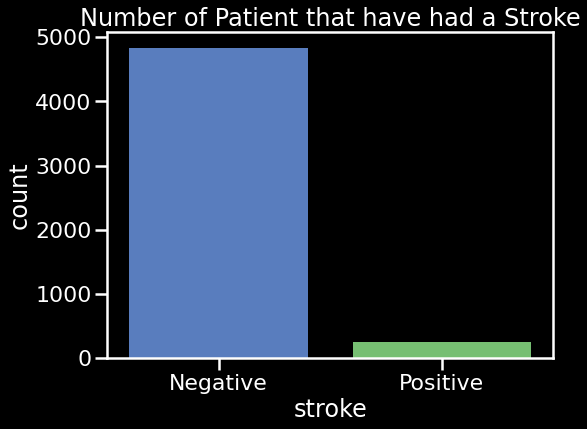

In [35]:
plt.figure(figsize=(8,6))
g = sns.countplot(data = df, x = 'stroke');
plt.title('Number of Patient that have had a Stroke');
sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted'])
g.set_xticklabels(['Negative','Positive']);

  - The Data is unbalanced more Negatives than Positives.

### **Feature Exploratory Visuals**

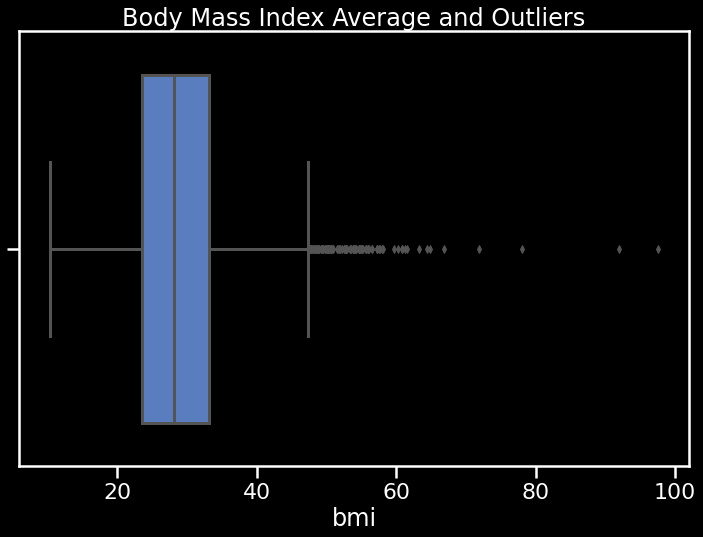

In [36]:
plt.figure(figsize=(12,8))
sns.boxplot(data = df, x = 'bmi');
plt.title('Body Mass Index Average and Outliers')
sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted']);

  - BMI has Outliers the average BMI is around 29 the highest is about 99.

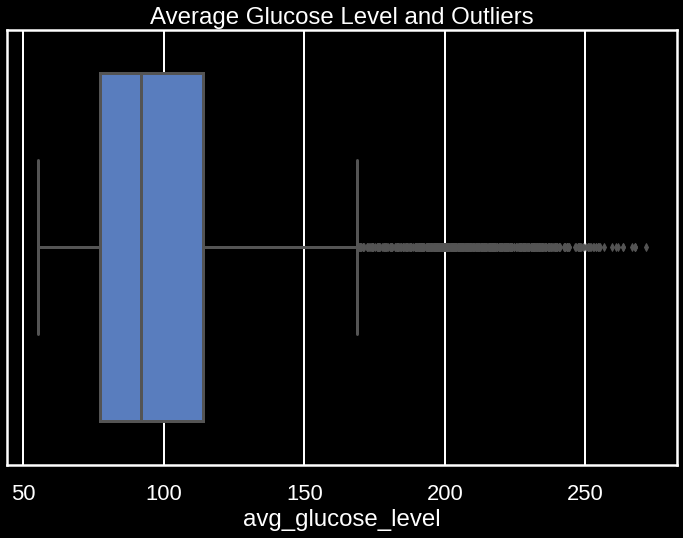

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(data = df, x = 'avg_glucose_level');
plt.title('Average Glucose Level and Outliers')
sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted'])

  - Average Glucose Level has Outliers, the average is 106, the highest is 271.

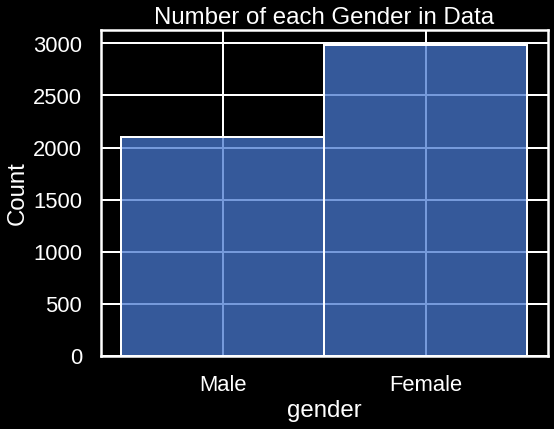

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data = df, x = 'gender');
plt.title('Number of each Gender in Data');sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted']);

  - There are about a Thousand More Women than men in The Data Set.

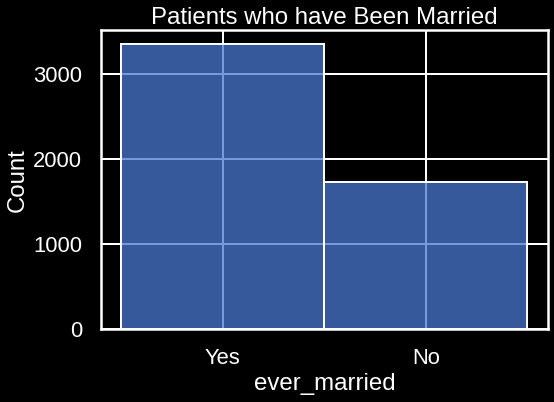

In [ ]:
sns.histplot(data = df, x = 'ever_married')
plt.title('Patients who have Been Married');
sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted']);

  - Twice as Many People in the Data Sets are Married.

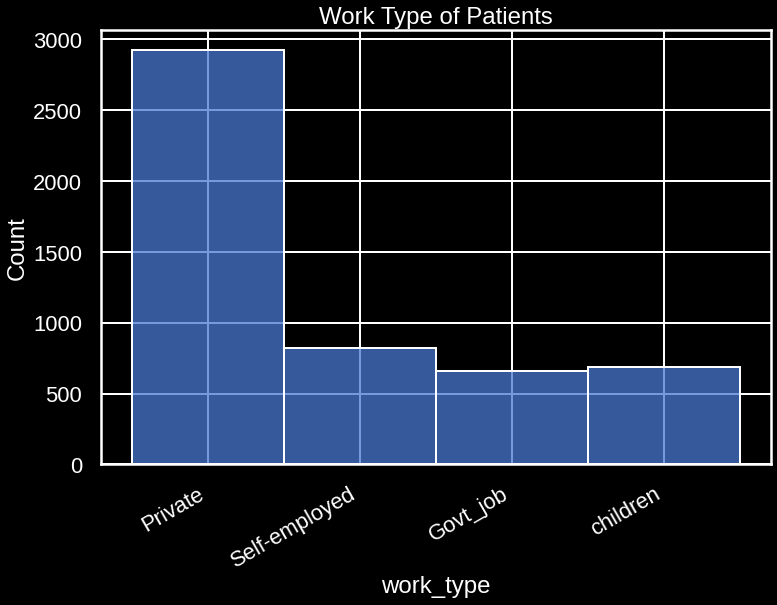

In [ ]:
plt.figure(figsize=(12,8))
sns.histplot(data = df, x = 'work_type');
plt.title('Work Type of Patients')
plt.xticks(rotation=30, horizontalalignment='right');sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted']);

  - About 3000 Privately Employed. All other employment is under 1000 and is Fairly even.

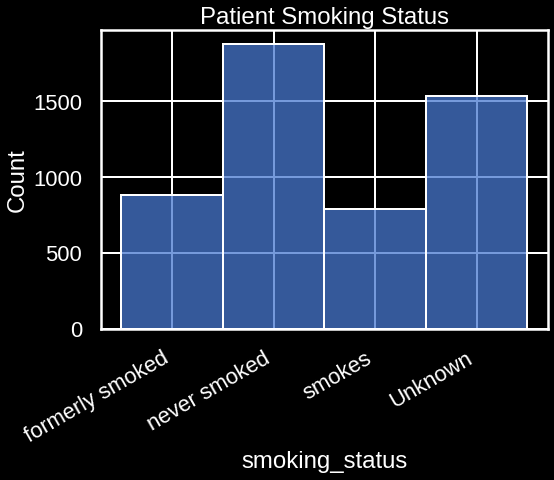

In [ ]:
sns.histplot(data = df, x= 'smoking_status');
plt.xticks(rotation = 30,horizontalalignment='right');
sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted'])
plt.title('Patient Smoking Status');

  - Never smoked has the most data then unknown formely smoked and smokers are pretty even around 800 in each.

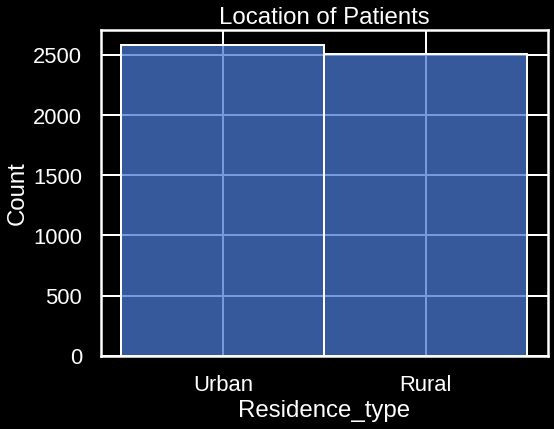

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(data = df, x = 'Residence_type')
plt.title('Location of Patients');
sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted']);

  - Residence Data is fairly even.

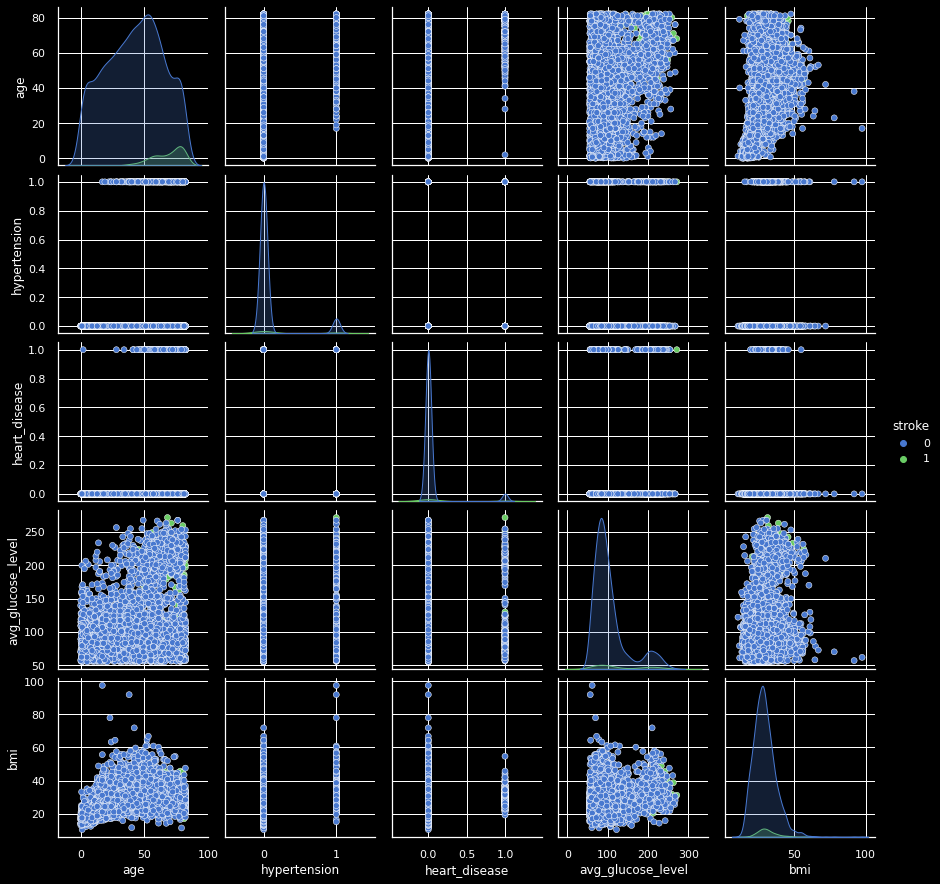

In [ ]:
sns.pairplot(df, hue='stroke');
sns.set(font_scale=40)
sns.set_context('notebook');
plt.style.use(['dark_background', 'seaborn-muted']);

  - The Pairplot helps me look at all data in one big picture.

## **Checking Correlation**
  - With Heat Map

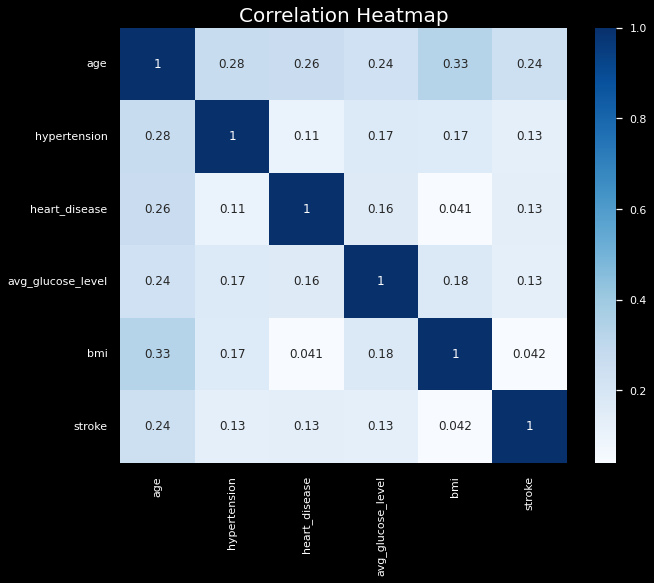

In [ ]:
corr = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap = 'Blues', annot = True);
sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted']);
plt.title('Correlation Heatmap', fontsize = 20);

  - Heat map show the strongest correlation for bmi and heart disease and bmi and stroke.

## **Multivariant Visualization**

#### Line Plot of BMI and Stroke

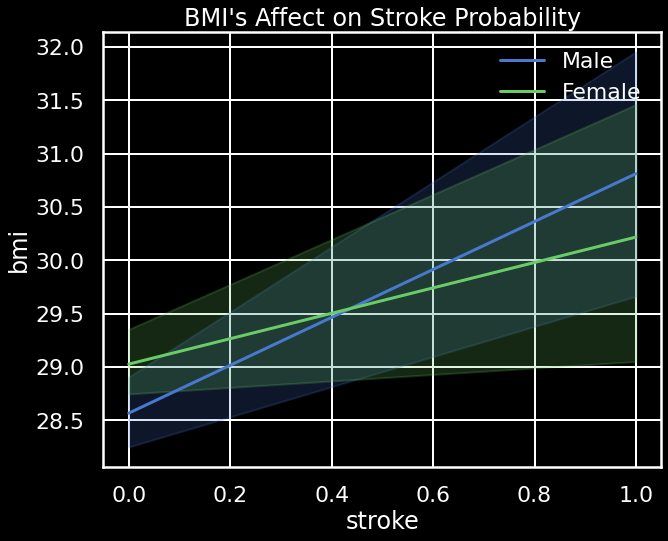

In [ ]:
plt.figure(figsize=(10,8))
sns.lineplot(data = df, y='bmi',x='stroke', hue = 'gender').set(title=
"BMI's Affect on Stroke Probability")
sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted']);
plt.legend(bbox_to_anchor = (1,1));

  - The higher the BMI the more likely to have a stroke. 

#### bar Plot of Work Type and Stroke

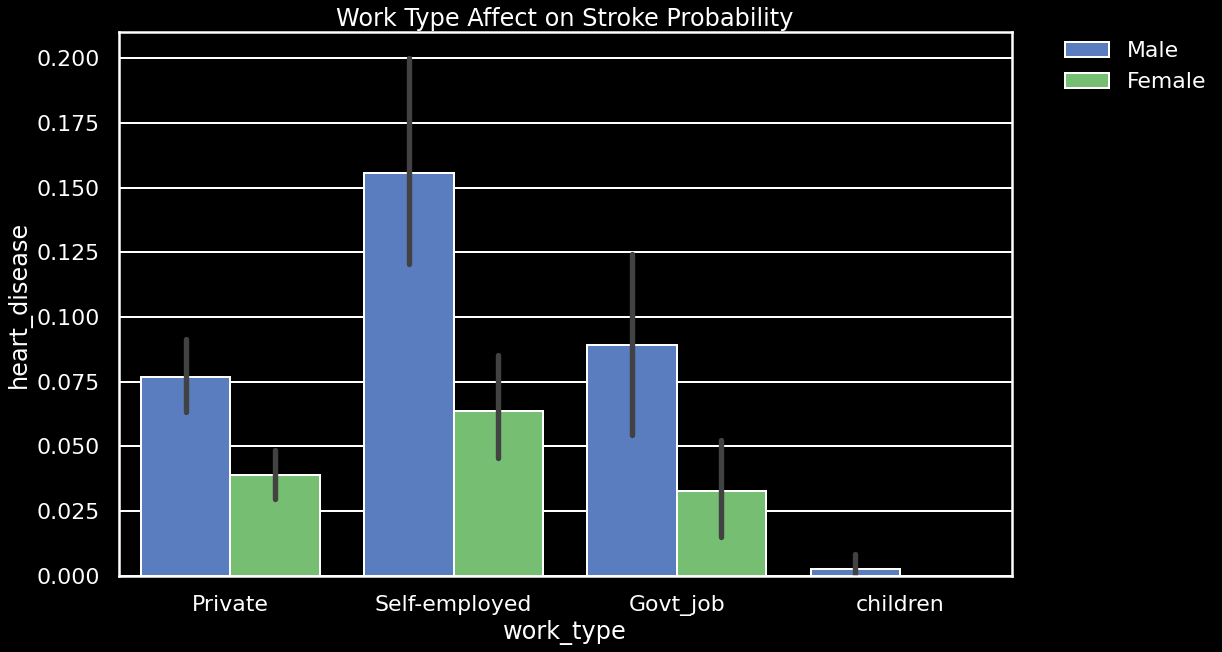

In [ ]:
plt.figure(figsize=(16,10))
sns.barplot(data = df, x='work_type',y='heart_disease', hue = 'gender').set(title="Work Type Affect on Stroke Probability");
sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);

  - Heart Disease has a small increase on the probability of having a Stroke.

#### Gender and Stroke

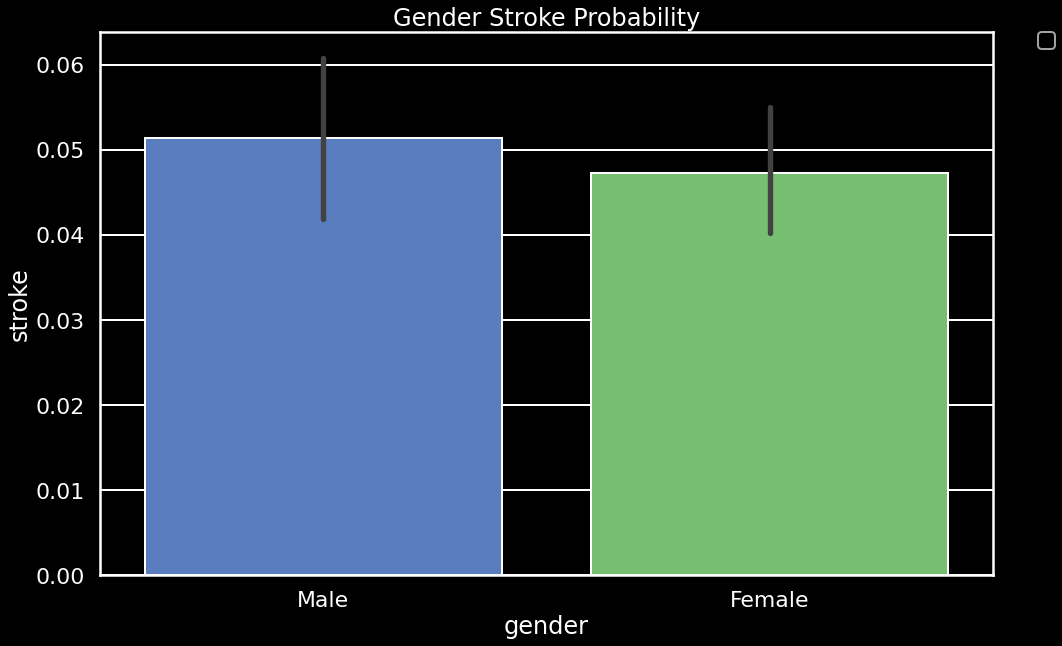

In [ ]:
plt.figure(figsize=(16,10))
sns.barplot(data = df, y='stroke',x='gender').set(title = 'Gender Stroke Probability')
sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted']);
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);

  - There is more frequency for a stroke as you get older.

#### Marital status and Stroke

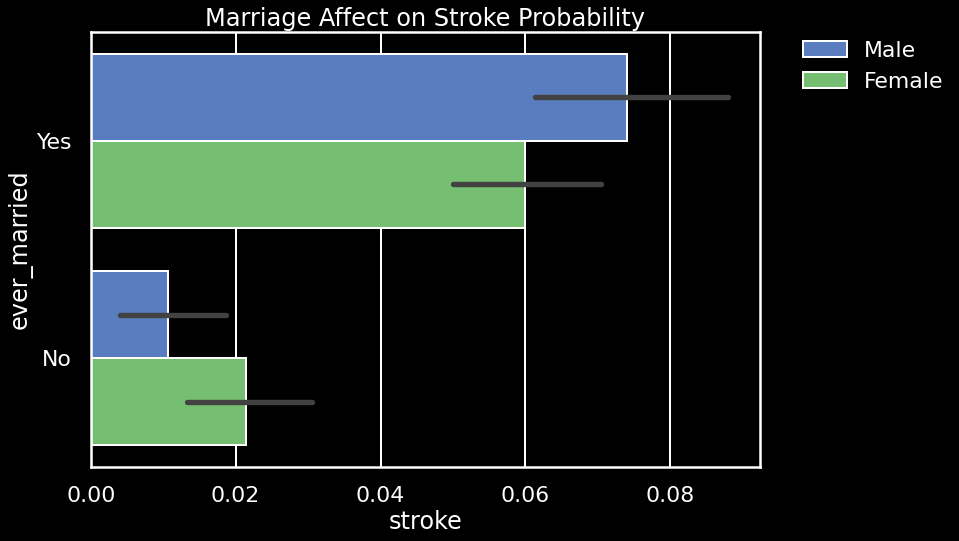

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data = df, x='stroke',y='ever_married', hue = 'gender').set(title='Marriage Affect on Stroke Probability')
sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);

  - Hypertension raise chances of Stroke.

## Visuals to Present to Stake Holders

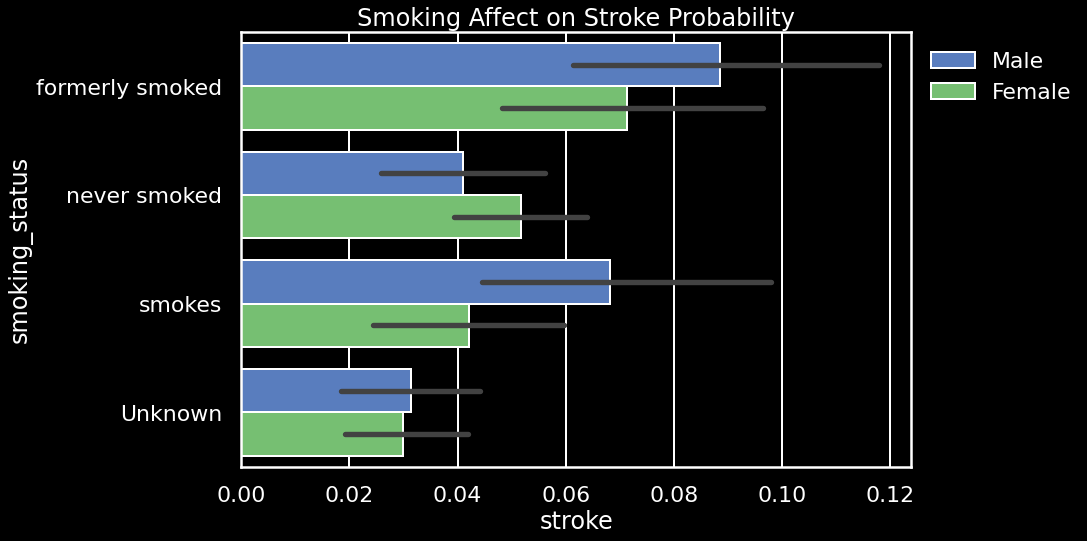

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data = df, x='stroke',y='smoking_status', hue = 'gender');
sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted'])
plt.title('Smoking Affect on Stroke Probability')
plt.legend(bbox_to_anchor = (1,1));

  - Former and current smokers are at more of a risk of stroke.

#### Glucose levels affect on Stroke

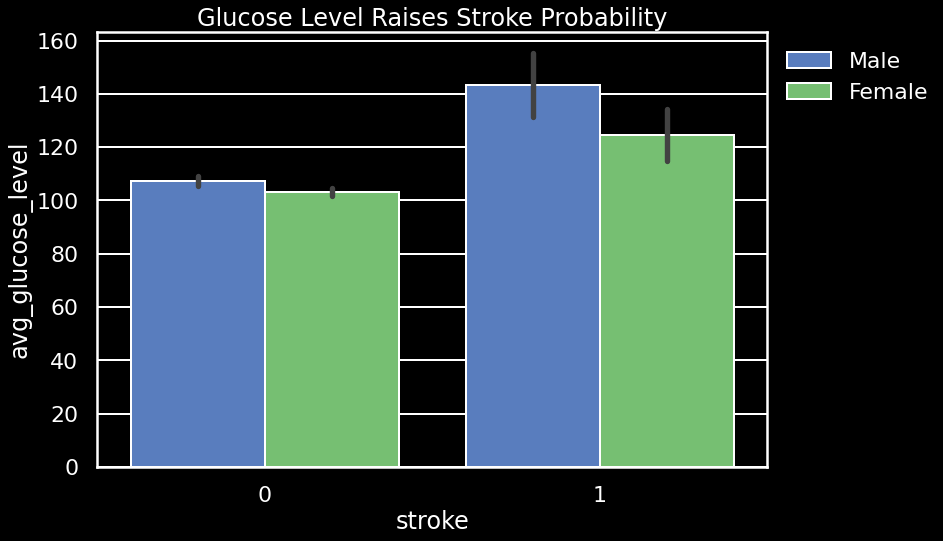

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data = df, x='stroke',y='avg_glucose_level', hue = 'gender');
sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted'])
plt.title('Glucose Level Raises Stroke Probability')
plt.legend(bbox_to_anchor = (1,1));

  - People that have had strokes have a higher glucose level. 

#### Heart Disease affect on Stroke

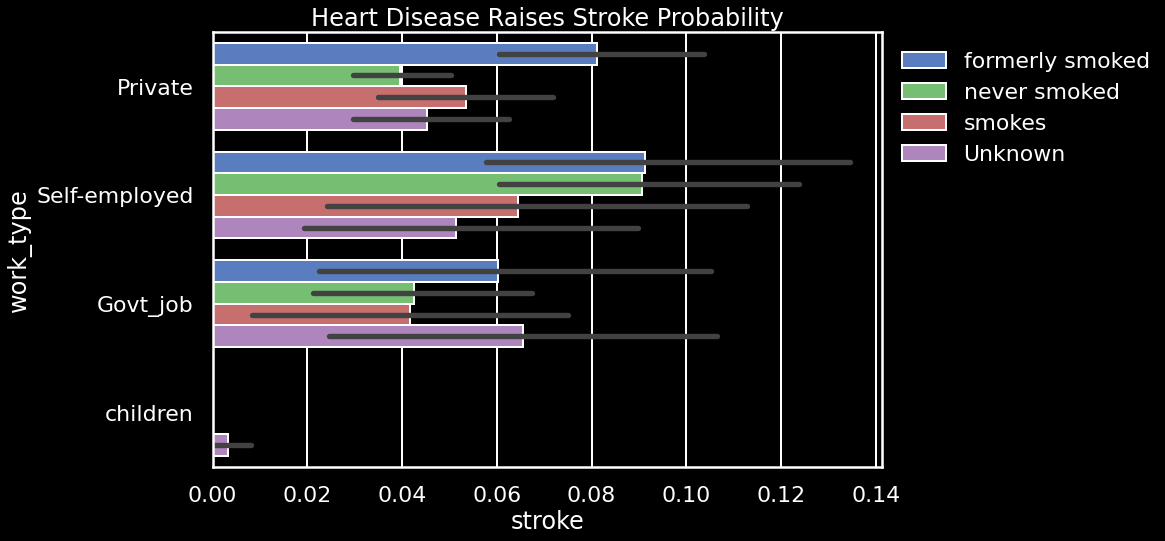

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data = df, x='stroke',y='work_type', hue = 'smoking_status');
sns.set_context('poster')
plt.style.use(['dark_background', 'seaborn-muted'])
plt.title('Heart Disease Raises Stroke Probability')
plt.legend(bbox_to_anchor = (1,1));

  - Self Employed People seem to have a higher rate of stroke.

### **Make a copy of DataFrame**

In [ ]:
ml_df = df.copy()

In [ ]:
ml_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
ml_df['stroke'].value_counts(normalize=False)

0    4838
1     249
Name: stroke, dtype: int64

In [ ]:
ml_df['stroke'].value_counts(normalize=True)

0    0.951052
1    0.048948
Name: stroke, dtype: float64

##Train Test Split the Data

In [ ]:
ml_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
target = 'stroke'
X = df.drop(columns = [target]).copy()
y = df[target].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

## **Preprocessing**

### **ColumnSelectors**

In [ ]:
#instantiate the selectors to for numeric and categorical data types
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')
#select the numeric columns of each type
num_columns = num_selector(X_train)
cat_columns = cat_selector(X_train)
#check our lists
print('numeric columns are', num_columns)
print('categorical columns are', cat_columns)

numeric columns are ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
categorical columns are ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [ ]:
# isolate the numeric columns
df_num = df[num_columns]
# isolate the columns with missing data
df_num.loc[:, df_num.isna().any()]

,bmi
id,
9046,36.6
51676,NaN
31112,32.5
60182,34.4
1665,24.0
...,...
18234,NaN
44873,40.0
19723,30.6


In [ ]:
X_train.isna().any()

gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
dtype: bool

In [ ]:
median_imputer = SimpleImputer(strategy='median')
median_imputer.fit(X_train[num_columns])
X_train.loc[:, num_columns] = median_imputer.transform(X_train[num_columns])
X_test.loc[:, num_columns] = median_imputer.transform(X_test[num_columns])

In [ ]:
X_train.isna().any()

gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                  False
smoking_status       False
dtype: bool

### **Transformers**

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
scaler = StandardScaler()

In [ ]:
#instantiate the selectors to for numeric and categorical data types
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

In [ ]:
median_imputer = SimpleImputer(strategy='median')

In [ ]:
numeric_pipe = make_pipeline(median_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

### **Tuples and ColumnTransformer**

In [ ]:
# create tuples of (imputer, selector) for each datatype
num_tuple = (numeric_pipe, num_selector)
cat_tuple = (ohe, cat_selector)
# instantiate ColumnTransformer
preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd3d0>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd370>)])

## **Modeling**

#### **Random Forest**

In [ ]:
rf = RandomForestClassifier(class_weight='balanced')
rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd3d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd370>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced'))])

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1210
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1272
   macro avg       0.48      0.50      0.49      1272
weighted avg       0.90      0.95      0.93      1272



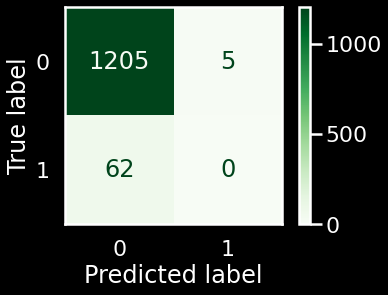

In [ ]:
evaluate_classification(rf_pipe, X_test, y_test)

In [ ]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(remainder='passthrough',
                     transformers=[('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd3d0>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd370>)])),
  ('randomforestclassifier', RandomForestClassifier(class_weight='balanced'))],
 'verbose': False,
 'columntransform

##### **GridSearchCV on Random Forest**

In [ ]:
#create and visualize our parameter grid
param_grid = {'randomforestclassifier__max_depth': [2,3,4,5,8],
              'randomforestclassifier__min_samples_leaf': [3,4,5,6,8],
              'randomforestclassifier__min_samples_split': [2, 3, 4, 5,6]}
 
pd.DataFrame(param_grid).T

,0,1,2,3,4
randomforestclassifier__max_depth,2,3,4,5,8
randomforestclassifier__min_samples_leaf,3,4,5,6,8
randomforestclassifier__min_samples_split,2,3,4,5,6


In [ ]:
rf_pipe_gs = GridSearchCV(rf_pipe, param_grid)
 
rf_pipe_gs.fit(X_train, y_train)
print('Best Random Forest Parameters:')
print(rf_pipe_gs.best_params_)
best_pipe = rf_pipe_gs.best_estimator_
print(f'Accuracy of best Random Forest model is: {best_pipe.score(X_test, y_test)}')

Best Random Forest Parameters:
{'randomforestclassifier__max_depth': 8, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__min_samples_split': 4}
Accuracy of best Random Forest model is: 0.8341194968553459


In [ ]:
rf2 = RandomForestClassifier(max_depth = 8, min_samples_leaf = 3, min_samples_split = 5,
                             class_weight = 'balanced')
rf2_pipe = make_pipeline(preprocessor, rf2)
rf2_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd3d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd370>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=8,
                                        min_samples_leaf=3,
                                        min_samples_split=5))])

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      1210
           1       0.16      0.50      0.24        62

    accuracy                           0.85      1272
   macro avg       0.57      0.68      0.58      1272
weighted avg       0.93      0.85      0.88      1272



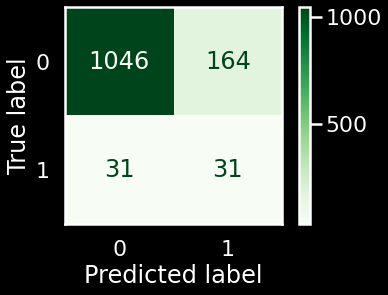

In [ ]:
evaluate_classification(rf2_pipe, X_test, y_test)

### **XGBoost**

In [ ]:
xgb = XGBClassifier(random_state=42)
## Create a model pipeline
xgb_pipe = make_pipeline(preprocessor, xgb)
## Fit the model
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd3d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                spa...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1210
           1       0.36      0.13      0.19        62

    accuracy                           0.95      1272
   macro avg       0.66      0.56      0.58      1272
weighted avg       0.93      0.95      0.93      1272



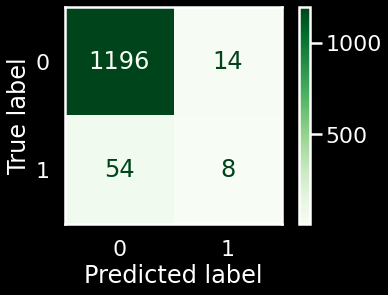

In [ ]:
evaluate_classification(xgb_pipe, X_test, y_test)

In [ ]:
xgb_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(remainder='passthrough',
                     transformers=[('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd3d0>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd370>)])),
  ('xgbclassifier',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylev

###### **GridSearchCV on XGBoost**

In [ ]:
#create and visualize our parameter grid
xgb_param_grid = {'xgbclassifier__learning_rate': [.1, .2, .3, .4],
              'xgbclassifier__gamma': [1,2,3,4],
              'xgbclassifier__n_estimators': [100, 150, 200, 250]}
 
pd.DataFrame(xgb_param_grid).T

,0,1,2,3
xgbclassifier__learning_rate,0.1,0.2,0.3,0.4
xgbclassifier__gamma,1.0,2.0,3.0,4.0
xgbclassifier__n_estimators,100.0,150.0,200.0,250.0


In [ ]:
xgb_pipe_gs = GridSearchCV(xgb_pipe, xgb_param_grid)
 
xgb_pipe_gs.fit(X_train, y_train)
print('Best XGBoost Parameters:')
print(xgb_pipe_gs.best_params_)
best_pipe = xgb_pipe_gs.best_estimator_
print(f'Accuracy of best XGBoost model is: {best_pipe.score(X_test, y_test)}')

Best XGBoost Parameters:
{'xgbclassifier__gamma': 4, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 100}
Accuracy of best XGBoost model is: 0.9504716981132075


In [ ]:
xgb2 = XGBClassifier(learning_rate = .2, gamma = 4, n_estimators = 100)
                             
xgb2_pipe = make_pipeline(preprocessor, xgb2)
xgb2_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd3d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                spa...
                               feature_types=None, gamma=4, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1210
           1       0.33      0.02      0.03        62

    accuracy                           0.95      1272
   macro avg       0.64      0.51      0.50      1272
weighted avg       0.92      0.95      0.93      1272



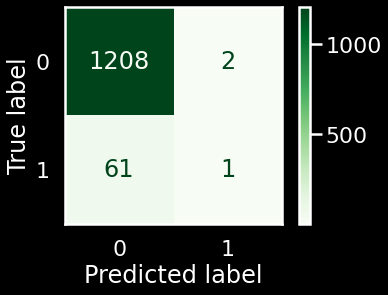

In [ ]:
evaluate_classification(xgb2_pipe, X_test, y_test)

### **KNeighbors**

In [ ]:
knn = KNeighborsClassifier()
knn_pipe = make_pipeline(preprocessor, knn)
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd3d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd370>)])),
                ('kneighborsclassifier', KNeighborsClassifier())])

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1210
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1272
   macro avg       0.48      0.50      0.49      1272
weighted avg       0.90      0.94      0.92      1272



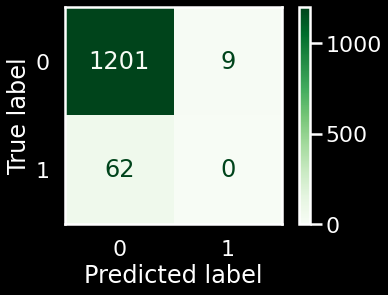

In [ ]:
evaluate_classification(knn_pipe, X_test, y_test)

In [ ]:
knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(remainder='passthrough',
                     transformers=[('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd3d0>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd370>)])),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(rema

##### **GridSearchCV KNN**

In [ ]:
#create and visualize our parameter grid
knn_param_grid = {'kneighborsclassifier__leaf_size': [30,40,50,60],
              'kneighborsclassifier__n_neighbors': [3,5,7,9],
              'kneighborsclassifier__p': [2,4,6,8]}
 
pd.DataFrame(knn_param_grid).T

,0,1,2,3
kneighborsclassifier__leaf_size,30,40,50,60
kneighborsclassifier__n_neighbors,3,5,7,9
kneighborsclassifier__p,2,4,6,8


In [ ]:
knn_pipe_gs = GridSearchCV(knn_pipe, knn_param_grid)
 
knn_pipe_gs.fit(X_train, y_train)
print('Best KNN Parameters:')
print(knn_pipe_gs.best_params_)
best_pipe = knn_pipe_gs.best_estimator_
print(f'Accuracy of best KNN model is: {best_pipe.score(X_test, y_test)}')

Best KNN Parameters:
{'kneighborsclassifier__leaf_size': 30, 'kneighborsclassifier__n_neighbors': 9, 'kneighborsclassifier__p': 4}
Accuracy of best KNN model is: 0.949685534591195


In [ ]:
knn2 = KNeighborsClassifier(leaf_size = 30, n_neighbors = 9, p = 4)
                             
knn2_pipe = make_pipeline(preprocessor, knn2)
knn2_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd3d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd370>)])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=9, p=4))])

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1210
           1       0.25      0.02      0.03        62

    accuracy                           0.95      1272
   macro avg       0.60      0.51      0.50      1272
weighted avg       0.92      0.95      0.93      1272



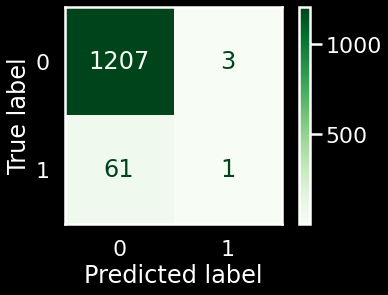

In [ ]:
evaluate_classification(knn2_pipe, X_test, y_test)

### **SMOTENC Models**

In [ ]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5087 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5087 non-null   object 
 1   age                5087 non-null   float64
 2   hypertension       5087 non-null   int64  
 3   heart_disease      5087 non-null   int64  
 4   ever_married       5087 non-null   object 
 5   work_type          5087 non-null   object 
 6   Residence_type     5087 non-null   object 
 7   avg_glucose_level  5087 non-null   float64
 8   bmi                4886 non-null   float64
 9   smoking_status     5087 non-null   object 
 10  stroke             5087 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 605.9+ KB


In [ ]:
## Create an instance of the transformer
smote = SMOTENC(categorical_features = [0,4,5,6,9],  sampling_strategy='auto', random_state=42)
# Split the dataset
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
## Display the value counts for y_train_smote
pd.Series(y_train_smote).value_counts()

0    3628
1    3628
Name: stroke, dtype: int64

##### **KNeighbors**

In [ ]:
## Create an instance of the model
knn_reg_smote = KNeighborsClassifier()
## Create a model pipeline
knn_reg_smote_pipe = smote_pipe(preprocessor, smote, knn_reg_smote)
## Fit the model
knn_reg_smote_pipe.fit(X_train_smote, y_train_smote)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd3d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd370>)])),
                ('smotenc',
                 SMOTENC(categorical_features=[0, 4, 5, 6, 9],
                         random_state=42)),
                ('kneighborsclassifier', KNeighborsClassifier())])

###### Compare 3 KNN Models

KNN SMOTE
              precision    recall  f1-score   support

           0       0.97      0.83      0.90      1210
           1       0.14      0.52      0.22        62

    accuracy                           0.82      1272
   macro avg       0.55      0.67      0.56      1272
weighted avg       0.93      0.82      0.86      1272



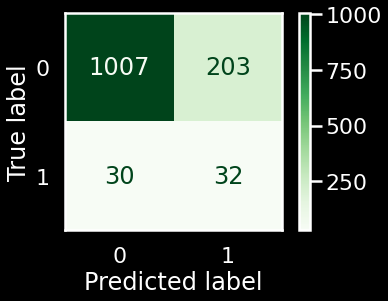


KNN GRIDSEARCH
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1210
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1272
   macro avg       0.48      0.50      0.49      1272
weighted avg       0.90      0.95      0.93      1272



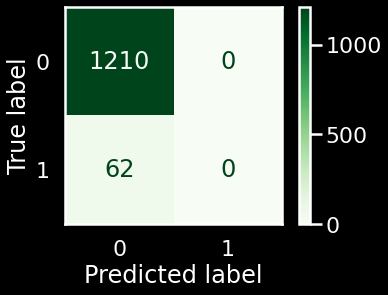


KNN
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1210
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1272
   macro avg       0.48      0.50      0.49      1272
weighted avg       0.90      0.95      0.93      1272



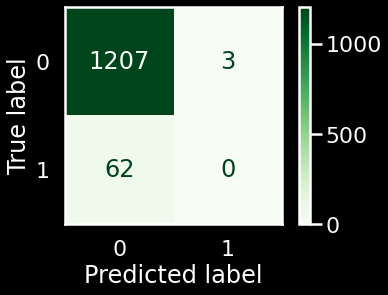

In [ ]:
print('KNN SMOTE')
evaluate_classification(knn_reg_smote_pipe, X_test, y_test)
print('')
print('KNN GRIDSEARCH')
evaluate_classification(knn2_pipe, X_test, y_test)
print('')
print('KNN')
evaluate_classification(knn_pipe, X_test, y_test)

#### **Random Forest**

In [ ]:
## Create an instance of the model
rf_reg_smote = RandomForestClassifier()
## Create a model pipeline
rf_reg_smote_pipe = smote_pipe(preprocessor, smote, rf_reg_smote)
## Fit the model
rf_reg_smote_pipe.fit(X_train_smote, y_train_smote)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd3d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd370>)])),
                ('smotenc',
                 SMOTENC(categorical_features=[0, 4, 5, 6, 9],
                         random_state=42)),
                ('randomforestclassifier', RandomForestClassifier())])

###### Compare 3 Random Forest Models

Random Forest SMOTE
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1210
           1       0.15      0.16      0.16        62

    accuracy                           0.91      1272
   macro avg       0.55      0.56      0.55      1272
weighted avg       0.92      0.91      0.92      1272



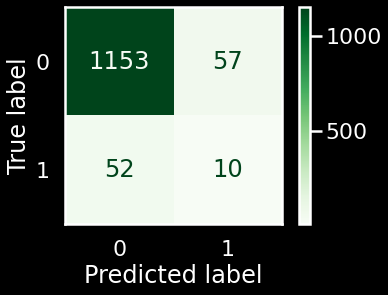


Random Forest GRIDSEARCH
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1210
           1       0.15      0.16      0.16        62

    accuracy                           0.92      1272
   macro avg       0.56      0.56      0.56      1272
weighted avg       0.92      0.92      0.92      1272



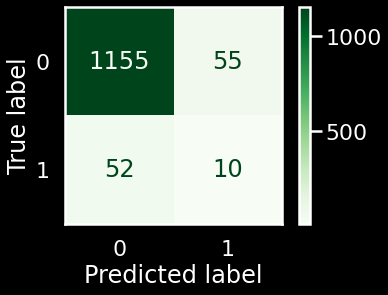


Random Forest
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1210
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1272
   macro avg       0.48      0.50      0.49      1272
weighted avg       0.90      0.95      0.93      1272



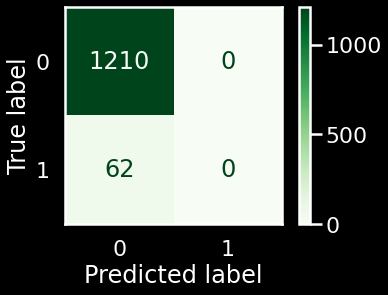

In [ ]:
print('Random Forest SMOTE')
evaluate_classification(rf_reg_smote_pipe, X_test, y_test)
print('')
print('Random Forest GRIDSEARCH')
evaluate_classification(rf2_pipe, X_test, y_test)
print('')
print('Random Forest')
evaluate_classification(rf_pipe, X_test, y_test)

#### **XGBoost**

In [ ]:
## Create an instance of the model
xgb_reg_smote = XGBClassifier()
## Create a model pipeline
xgb_reg_smote_pipe = smote_pipe(preprocessor, smote, xgb_reg_smote)
## Fit the model
xgb_reg_smote_pipe.fit(X_train_smote, y_train_smote)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1be5cfd3d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                spa...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

XGBoost SMOTE
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1210
           1       0.15      0.13      0.14        62

    accuracy                           0.92      1272
   macro avg       0.55      0.55      0.55      1272
weighted avg       0.92      0.92      0.92      1272



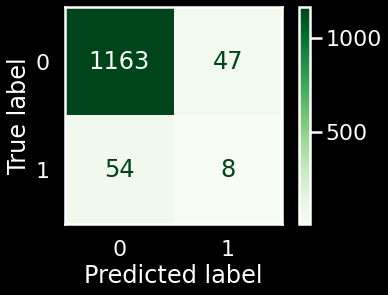


XGBoost GRIDSEARCH
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1210
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1272
   macro avg       0.48      0.50      0.49      1272
weighted avg       0.90      0.95      0.93      1272



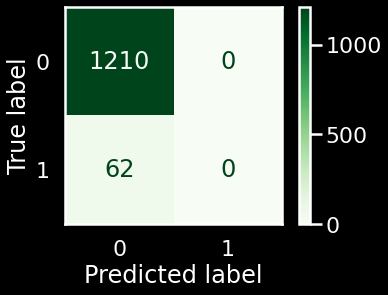


XGBoost
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1210
           1       0.33      0.05      0.08        62

    accuracy                           0.95      1272
   macro avg       0.64      0.52      0.53      1272
weighted avg       0.92      0.95      0.93      1272



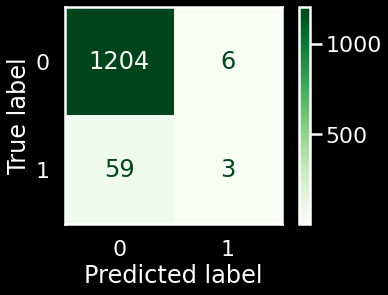

In [ ]:
print('XGBoost SMOTE')
evaluate_classification(xgb_reg_smote_pipe, X_test, y_test)
print('')
print('XGBoost GRIDSEARCH')
evaluate_classification(xgb2_pipe, X_test, y_test)
print('')
print('XGBoost')
evaluate_classification(xgb_pipe, X_test, y_test)

###### Compare 3 XGBoost Models

## **Top 3 Performing Models**

KNN with SMOTE
              precision    recall  f1-score   support

           0       0.97      0.83      0.90      1210
           1       0.14      0.52      0.22        62

    accuracy                           0.82      1272
   macro avg       0.55      0.67      0.56      1272
weighted avg       0.93      0.82      0.86      1272



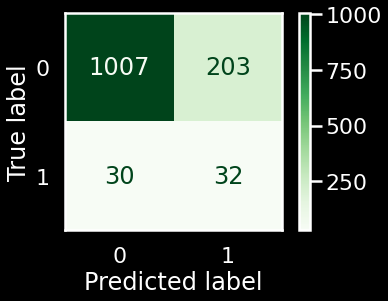

Random Forest with SMOTE
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1210
           1       0.15      0.16      0.16        62

    accuracy                           0.91      1272
   macro avg       0.55      0.56      0.55      1272
weighted avg       0.92      0.91      0.92      1272



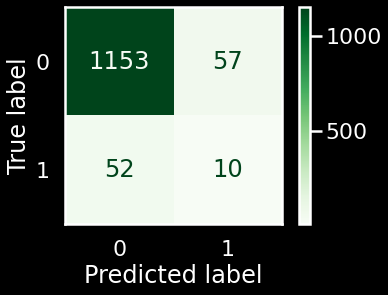

XGBoost with SMOTE
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1210
           1       0.15      0.13      0.14        62

    accuracy                           0.92      1272
   macro avg       0.55      0.55      0.55      1272
weighted avg       0.92      0.92      0.92      1272



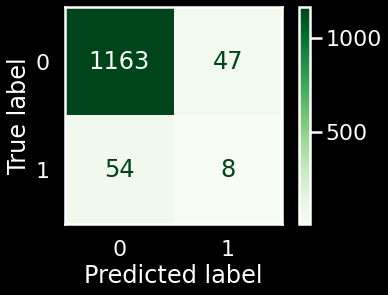

In [ ]:
print('KNN with SMOTE')
evaluate_classification(knn_reg_smote_pipe, X_test, y_test)
print('Random Forest with SMOTE')
evaluate_classification(rf_reg_smote_pipe, X_test, y_test)
print('XGBoost with SMOTE')
evaluate_classification(xgb_reg_smote_pipe, X_test, y_test)

## Get metrics for Top 3 Models

In [ ]:
def model_metrics(pipe, x_train, y_train, x_test, y_test, 
                       model_name='Regression Model', ):
  ## Train
  mae = round(mean_absolute_error(y_train, pipe.predict(x_train)),4)
  mse = round(mean_squared_error(y_train, pipe.predict(x_train)),4)
  rmse = round(np.sqrt(mean_squared_error(y_train, pipe.predict(x_train))),4)
  r2 = round(r2_score(y_train, pipe.predict(x_train)),7)
  print(f'{model_name} Train Scores')
  print(f'MAE: {mae} \nMSE: {mse} \nRMSE: {rmse} \nR2: {r2}\n')

  ## Test
  mae = round(mean_absolute_error(y_test, pipe.predict(x_test)),4)
  mse = round(mean_squared_error(y_test, pipe.predict(x_test)),4)
  rmse = round(np.sqrt(mean_squared_error(y_test, pipe.predict(x_test))),4)
  r2 = round(r2_score(y_test, pipe.predict(x_test)),7)

  ## Display the metrics for the model
  print(f'{model_name} Test Scores')
  print(f'MAE: {mae} \nMSE: {mse} \nRMSE: {rmse} \nR2: {r2}\n')


In [ ]:
model_metrics(knn_reg_smote_pipe, x_train = X_train, y_train = y_train, 
              x_test= X_test,y_test = y_test, model_name = 'KNeighbors with SMOTE')

KNeighbors with SMOTE Train Scores
MAE: 0.1324 
MSE: 0.1324 
RMSE: 0.3638 
R2: -1.8397299

KNeighbors with SMOTE Test Scores
MAE: 0.1832 
MSE: 0.1832 
RMSE: 0.428 
R2: -2.9506265



In [ ]:
model_metrics(rf_reg_smote_pipe, x_train = X_train, y_train = y_train, 
              x_test= X_test,y_test = y_test, model_name = 'Random Forest with SMOTE')

Random Forest with SMOTE Train Scores
MAE: 0.0 
MSE: 0.0 
RMSE: 0.0 
R2: 1.0

Random Forest with SMOTE Test Scores
MAE: 0.0857 
MSE: 0.0857 
RMSE: 0.2927 
R2: -0.8481472



In [ ]:
model_metrics(xgb_reg_smote_pipe, x_train = X_train, y_train = y_train, 
              x_test= X_test,y_test = y_test, model_name = 'XGBoost with SMOTE')

XGBoost with SMOTE Train Scores
MAE: 0.0031 
MSE: 0.0031 
RMSE: 0.0561 
R2: 0.9325213

XGBoost with SMOTE Test Scores
MAE: 0.0794 
MSE: 0.0794 
RMSE: 0.2818 
R2: -0.7125033



### Try PCA to Improve Model

In [ ]:
ml_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:


cols = ['gender', 'ever_married', 'work_type', 'Residence_type','smoking_status']
#
# Encode labels of multiple columns at once
#
ml_df[cols] = ml_df[cols].apply(LabelEncoder().fit_transform)
#
# Print head
#
ml_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,1,67.0,0,1,1,1,1,228.69,36.6,1,1
51676,0,61.0,0,0,1,2,0,202.21,28.1,2,1
31112,1,80.0,0,1,1,1,0,105.92,32.5,2,1
60182,0,49.0,0,0,1,1,1,171.23,34.4,3,1
1665,0,79.0,1,0,1,2,0,174.12,24.0,2,1


In [ ]:
median_bmi = ml_df['bmi'].median()
ml_df['bmi'].fillna(median_bmi, inplace = True)
ml_df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [ ]:
X = ml_df.drop(columns ='stroke')
y = ml_df['stroke']


In [ ]:
# Instantiate Standard Scaler
scaler = StandardScaler()
# Fit & transform data.
scaled_df = scaler.fit_transform(X)

In [ ]:
# Instantiate & fit data using PCA
pca = PCA()
pca.fit(scaled_df)

PCA()

In [ ]:
pd.Series(pca.explained_variance_ratio_) 

0    0.268726
1    0.126653
2    0.100168
3    0.094837
4    0.090489
5    0.083389
6    0.080804
7    0.070692
8    0.054924
9    0.029319
dtype: float64

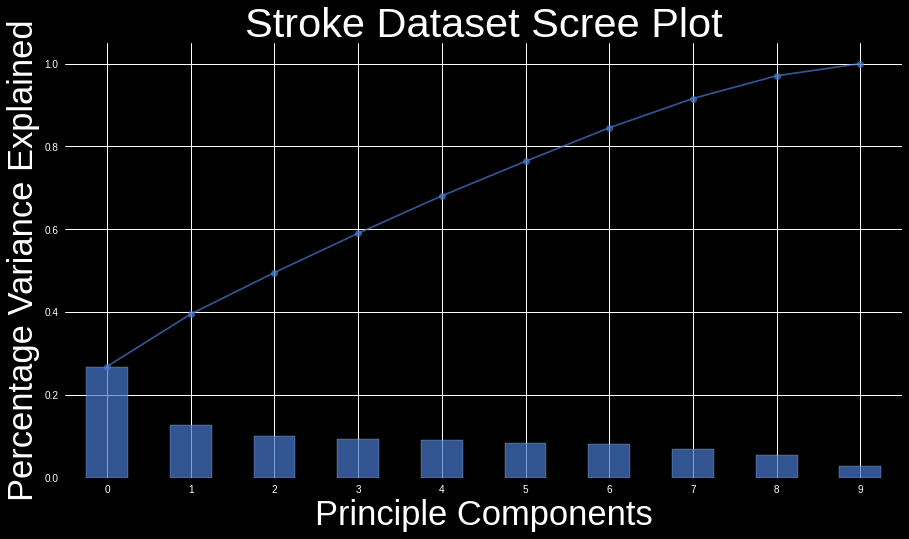

In [ ]:
# Lets visual the cummulative sum of the variances 

plt.style.use(['dark_background', 'seaborn-muted'])
plt.figure(figsize=(15,8))
exp_var = pd.Series(pca.explained_variance_ratio_)

exp_var.plot(kind="bar", alpha=0.7) # plot bar chart

# Calculate the amount of variance explained added by each additional component
total = 0
var_ls = []
for x in exp_var:
    total = total+x
    var_ls.append(total)

pd.Series(var_ls).plot(marker="o", alpha=0.7) #plot line chart of increasing variances
plt.xlabel("Principle Components", fontsize="x-large")
plt.ylabel("Percentage Variance Explained", fontsize="x-large")
plt.title("Stroke Dataset Scree Plot", fontsize="xx-large")
plt.style.use(['dark_background', 'seaborn-muted'])
plt.show();

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# Instantiate Standard Scaler
scaler = StandardScaler()
# Fit & transform data.
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [ ]:
# fit PCA
pca = PCA(n_components = 3)
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

# Created two model to compare training time
logreg_noPCA = LogisticRegression(max_iter=2085) # Set max_iter so model reaches convergence
logreg = LogisticRegression()

In [ ]:
# Measure how long it takes to train without PCA
%timeit logreg_noPCA.fit(X_train, y_train)

220 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Measure how long it takes to train with PCA

%timeit logreg.fit(X_train_pca, y_train)

10 ms ± 3.57 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# Checking the accurancy of our model with PCA 
print('Testing accuracy:', logreg.score(X_test_pca, y_test))

Testing accuracy: 0.9378930817610063


In [ ]:
print('Testing accuracy:', logreg_noPCA.score(X_test, y_test))

Testing accuracy: 0.9363207547169812


In [ ]:
pipe = make_pipeline(
    StandardScaler(),
    PCA(n_components=3),
    LogisticRegression()
)

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.9378930817610063

In [ ]:
pred = pipe.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1192
           1       1.00      0.01      0.02        80

    accuracy                           0.94      1272
   macro avg       0.97      0.51      0.50      1272
weighted avg       0.94      0.94      0.91      1272



              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1192
           1       1.00      0.01      0.02        80

    accuracy                           0.94      1272
   macro avg       0.97      0.51      0.50      1272
weighted avg       0.94      0.94      0.91      1272



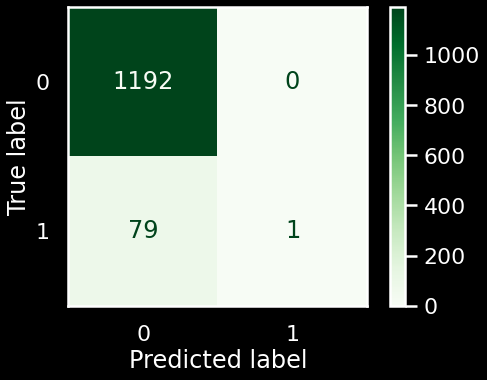

In [ ]:
evaluate_classification(pipe, X_test, y_test)

### **Model Recomendations**

  - The Dataset represents a Medical data set so the most important thing to avoid would be false positives. The model we should use is the KNN SMOTE model it had the least amount of false positives and the most true positive. 